**INTEGRANTES**

Amanda Flores Aravena

Esteban Fredes Reyes

Felipe Inostroza Ordenes

# Importaciones y Funciones

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from matplotlib.lines import Line2D
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay



In [68]:
# Dicciónario para convertir los valores a categorías
LABELS = {0: "LowQuality", 1: "Average", 2: "HighQuality"}
BINS = [0, 4.5, 5.5, 10]

In [69]:
# Función para cargar ambos datasets y convertir la columna quality a categorías
def cargar_datos(dataset):
    ds = pd.read_csv(dataset, sep=";")
    ds["quality_cat"] = pd.cut(ds["quality"], bins=BINS, labels=[0, 1, 2])
    return ds

In [70]:
# Función para crear una nueva columna con las categorías sin modificar los valores originales
def categorizar(dataset):
    dataset["quality_cat"] = pd.cut(dataset["quality"], bins=BINS, labels=[0, 1, 2])
    return dataset

In [71]:
# Función para definir la variable dependiente en clasificación y regresión
def dividir_x_y(df, tipo):
    if tipo == "categorico":
        x = df.drop(["quality", "quality_cat"], axis=1)
        y = df["quality_cat"]
    else:
        x = df.drop(["quality", "quality_cat"], axis=1)
        y = df["quality"]

    return x, y

In [72]:
# Función para normalizar los datos
def normalizar(x, y):
    scaler = StandardScaler()
    x_scaled = scaler.fit_transform(x)
    y_onehot = keras.utils.to_categorical(y)
    return x_scaled, y_onehot


In [73]:
# Función para configurar y ejecutar el modelo de clasificación
def clasificacion(X_scaled, y_onehot, fun_act):
    activation_fn = fun_act

    # Crear el modelo de clasificación con 3 capas de 64, 32 neuronas y 1 neurona por cada clase de salida
    classification_model = tf.keras.Sequential([
        tf.keras.layers.Dense(64, activation=activation_fn, input_shape=(X_scaled.shape[1],)),
        tf.keras.layers.Dense(32, activation=activation_fn),
        tf.keras.layers.Dense(3, activation='softmax')
    ])

    # Compilar el modelo de clasificación con optimizador Adam, función de pérdidad Categorical Cross-Entropy, y de métrica de evaluación la exactitud
    classification_model.compile(optimizer='adam',
                                loss='categorical_crossentropy',
                                metrics=['accuracy'])

    # K-fold cross validation para el modelo de clasificación
    k = 5
    kf = KFold(n_splits=k, shuffle=True)

    acc = []
    loss = []
    val_acc = []
    val_loss = []
    history_array = []
    conf_matrices = []

    # Entrenar el modelo de clasificación con 5-fold cross validation
    for train_index, val_index in kf.split(X_scaled):
        X_train, X_val = X_scaled[train_index], X_scaled[val_index]
        y_train, y_val = y_onehot[train_index], y_onehot[val_index]
        X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.2, random_state=42, stratify=y_val)
        
        history = classification_model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0, callbacks=[tf.keras.callbacks.History()], validation_data=(X_val, y_val))  # type: ignore
        history_array.append(history)
        acc.extend(history.history['accuracy'])
        loss.extend(history.history['loss'])
        val_acc.extend(history.history['val_accuracy'])
        val_loss.extend(history.history['val_loss'])
        

        val_predictions = classification_model.predict(X_test)
        val_predictions = np.argmax(val_predictions, axis=1)
        val_true_labels = np.argmax(y_test, axis=1)
        
        # obtener la matriz de confusion
        conf_matrix = confusion_matrix(val_true_labels, val_predictions)
        conf_matrices.append(conf_matrix)
        
    # Se imprime el promedio de los valores retornados realizando la cross validation
    print("\nPrecision con función de activación ", fun_act, ": ", np.mean(acc))
    print("Costo de perdida con función de activación ", fun_act, ": ", np.mean(loss))
    
    return acc, loss, val_acc, val_loss, history_array, np.mean(conf_matrices, axis=0).astype(int)

In [74]:
# Función para configurar y ejecutar el modelo de regresión
def regresion(X_scaled, y, fun_act):
    activation_fn = fun_act
    # Crear el modelo de regresión con 3 capas de 64, 32 neuronas y 1 neurona de salida
    regression_model = tf.keras.Sequential([
        tf.keras.layers.Dense(64, activation=activation_fn, input_shape=(X_scaled.shape[1],)),
        tf.keras.layers.Dense(32, activation=activation_fn),
        tf.keras.layers.Dense(1)
    ])

    # Compilar el modelo de regresión con optimizador Adam, función de pérdidad Error cuadrático medio, y de métricas de evaluación el error absoluto y cuadrático medio 
    regression_model.compile(optimizer='adam', loss='mse', metrics=['mae', 'mse'])

    # K-fold cross validation para el modelo de regresión
    k = 5
    kf = KFold(n_splits=k, shuffle=True)

    mse_scores = []
    mae_scores = []
    
    loss_values = []

    # Entrenar el modelo de regresión con 5-fold cross validation
    for train_index, val_index in kf.split(X_scaled):
        X_train, X_val = X_scaled[train_index], X_scaled[val_index]
        y_train, y_val = y[train_index], y[val_index]
        
        history = regression_model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0, callbacks=[tf.keras.callbacks.History()])
        loss_values.extend(history.history['loss'])
        
        val_predictions = regression_model.predict(X_val).flatten()
        mse = mean_squared_error(y_val, val_predictions)
        mae = mean_absolute_error(y_val, val_predictions)
        mse_scores.append(mse)
        mae_scores.append(mae)
        
    # Se imprime el promedio de los valores retornados realizando la cross validation   
    print("\nMSE con función de activación ", fun_act, ": ", np.mean(mse_scores))
    print("MAE con función de activación ", fun_act, ": ", np.mean(mae_scores))
    return np.mean(mse_scores), np.mean(mae_scores), loss_values

In [75]:
def grafica_comparativa(clas_sigmoide, clas_tanh):
    # Generar una paleta de colores
    colores = sns.color_palette("husl", 4)
    
    # Graficar la función de pérdida y el accuracy
    sns.lineplot(data=clas_sigmoide[0], color=colores[0]) # type: ignore
    sns.lineplot(data=clas_sigmoide[1], color=colores[1]) # type: ignore
    sns.lineplot(data=clas_tanh[0], color=colores[2]) # type: ignore
    sns.lineplot(data=clas_tanh[1], color=colores[3]) # type: ignore
    
    plt.xlabel('Época')
    plt.ylabel('Pérdida/Accuracy')
    plt.title('Función de pérdida/Accuracy durante el entrenamiento')
    
    # Crear la leyenda con los colores correspondientes
    labels = ['Accuracy Sigmoide', 'Loss Sigmoide', 'Accuracy Tanh', 'Loss Tanh']
    handles = [Line2D([0], [0], color=colores[i], label=labels[i]) for i in range(4)] # type: ignore
    plt.legend(handles=handles, loc='upper left', bbox_to_anchor=(1, 1))
    
    plt.show()

In [76]:
def matriz_comparativa(clas_sigmoide, clas_tanh):
    fig, axs = plt.subplots(1, 2, figsize=(12, 3))
    fig.suptitle('Matriz de confusión')
    disp = ConfusionMatrixDisplay(clas_sigmoide[5], display_labels=['LowQuality', 'Average', 'HighQuality']).plot(ax=axs[0])
    disp.ax_.set_title('Sigmoide')
    disp = ConfusionMatrixDisplay(clas_tanh[5], display_labels=['LowQuality', 'Average', 'HighQuality']).plot(ax=axs[1])
    disp.ax_.set_title('Tanh')
    plt.show()

In [77]:
def grafica_reg(reg_sigmoide, reg_tanh):
    # Se grafica la función de pérdida
    # tamaño de la figura
    plt.figure(figsize=(12, 3))
    plt.plot(reg_sigmoide[2], label='Sigmoid')
    plt.plot(reg_tanh[2], label='Tanh')
    plt.xlabel('Época')
    plt.ylabel('Pérdida')
    plt.title('Función de pérdida durante el entrenamiento')
    plt.legend()
    plt.show()

In [78]:
# Esta función entrega tablas comparativas con las funciones Sigmoide y Tangente hiperbólica
def tabla_comparative(sigmoide, tanh, val1, val2):
    return pd.DataFrame(
        {
            "Función de activación": [val1, val2],
            "Sigmoid": [np.mean(sigmoide[0]), np.mean(sigmoide[1])],
            "Tanh": [np.mean(tanh[0]), np.mean(tanh[1])]
        }
    )

# Vino Blanco

In [79]:
vino_blanco = cargar_datos("Data/winequality-white.csv")

## Modelo de clasificacion usando Red Neuronal

In [80]:
x, y = dividir_x_y(vino_blanco, "categorico") # regresion o categorico
x_scaled, y_onehot = normalizar(x, y)

In [81]:
clas_sigmoide = clasificacion(x_scaled, y_onehot, "sigmoid")

7/7 [==============================] - 0s 3ms/step

Precision con función de activación  sigmoid :  0.734165186882019
Costo de perdida con función de activación  sigmoid :  0.5983824300765991


In [82]:
clas_tanh = clasificacion(x_scaled, y_onehot, "tanh")

7/7 [==============================] - 0s 4ms/step

Precision con función de activación  tanh :  0.7697255909442902
Costo de perdida con función de activación  tanh :  0.5318230330944062


## Modelo de Regresion usando Red Neuronal

In [83]:
x, y = dividir_x_y(vino_blanco, "regresion") # regresion o categorico
x_scaled, _ = normalizar(x, y)

In [84]:
reg_sigmoide = regresion(x_scaled, y, "sigmoid")

31/31 [==============================] - 0s 2ms/step

MSE con función de activación  sigmoid :  0.5529151634028655
MAE con función de activación  sigmoid :  0.5749856999549102


In [85]:
reg_tanh = regresion(x_scaled, y, "tanh")

31/31 [==============================] - 0s 2ms/step

MSE con función de activación  tanh :  0.5146654607537087
MAE con función de activación  tanh :  0.5600379543052612


## Análisis de los Resultados

### Modelo de Classification

Para el modelo de clasificación de vinos blancos, podemos ver que los resultados son dentro de todo similares, teniendo en cuenta esto, la funcion tangente hiperbólica (tanh) presenta un menor costo de pérdida a comparanción de la función sigmoidal. Lo que nos lleva a concluir que la función tangente hiperbólica sería la mas adecuada a implementar en este modelo. Se puede observar que la exactitud (Accuracy) al utilizar la función tangente hiperbolica levemente mayor que la de función sigmoidal. Sin embargo, es importante considerar que esta métrica puede llegar a ser no la ideal al momento de realizar las evaluaciones ya que como sabemos gracias a los laboratorios anteriores, el dataset se encuentra desbalanceado.

In [86]:
tabla_comparative(clas_sigmoide, clas_tanh, "Precisión", "Costo de perdida")

,Función de activación,Sigmoid,Tanh
0,Precisión,0.734165,0.769726
1,Costo de perdida,0.598382,0.531823


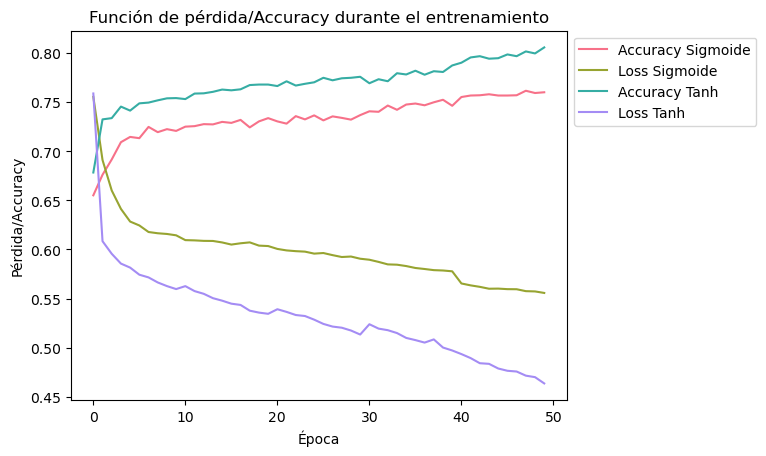

In [87]:
grafica_comparativa(clas_sigmoide, clas_tanh)

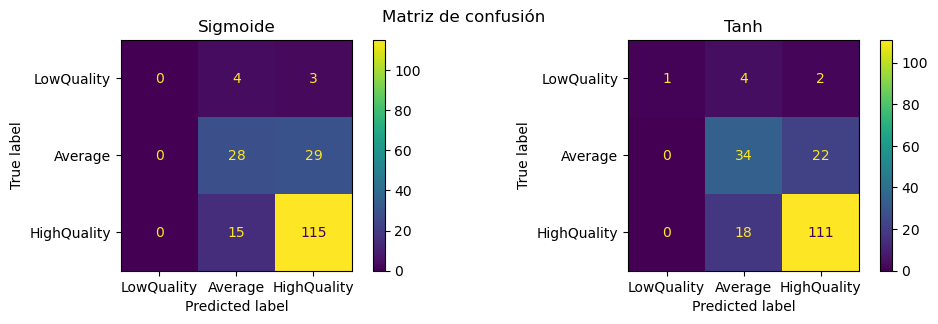

In [88]:
# Se imprime la matriz de confusión
matriz_comparativa(clas_sigmoide, clas_tanh)

### Modelo de Regression
Para el modelo de regresión de vinos blancos podemos ver que los errores (cuadrático y absoluto medio), son dentro de todo similares, teniendo en cuenta esto, la funcion tangente hiperbólica (tanh) presenta errores mas pequeños a comparanción de la función sigmoidal. Lo que nos lleva a concluir que la función de activación de la tangente hiperbólica sería la mas adecuada a implementar en este modelo.

In [89]:
tabla_comparative(reg_sigmoide, reg_tanh, "MSE", "MAE")

,Función de activación,Sigmoid,Tanh
0,MSE,0.552915,0.514665
1,MAE,0.574986,0.560038


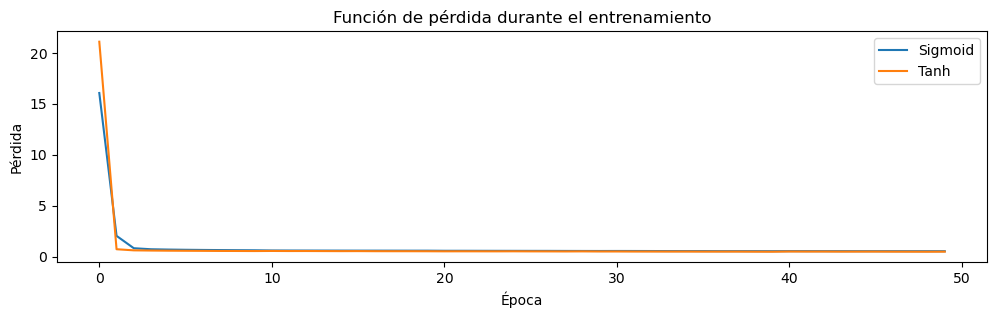

In [90]:
grafica_reg(reg_sigmoide, reg_tanh)


# Vino Tinto

In [91]:
vino_tinto = cargar_datos("Data/winequality-red.csv")

## Modelo de clasificacion usando Red Neuronal


In [92]:
x, y = dividir_x_y(vino_tinto, "categorico") # regresion o categorico
x_scaled, y_onehot = normalizar(x, y)

In [93]:
clas_sigmoide = clasificacion(x_scaled, y_onehot, "sigmoid")

2/2 [==============================] - 0s 6ms/step

Precision con función de activación  sigmoid :  0.7155553174018859
Costo de perdida con función de activación  sigmoid :  0.6471296310424804


In [94]:
clas_tanh = clasificacion(x_scaled, y_onehot, "tanh")

2/2 [==============================] - 0s 3ms/step

Precision con función de activación  tanh :  0.740662624835968
Costo de perdida con función de activación  tanh :  0.5864668500423431


## Modelo de Regresion usando Red Neuronal

In [95]:
x, y = dividir_x_y(vino_tinto, "regresion") # regresion o categorico
x_scaled, _ = normalizar(x, y)

In [96]:
reg_sigmoide = regresion(x_scaled, y, "sigmoid")

10/10 [==============================] - 0s 3ms/step

MSE con función de activación  sigmoid :  0.46182525782364525
MAE con función de activación  sigmoid :  0.527262112288079


In [97]:
reg_tanh = regresion(x_scaled, y, "tanh")

10/10 [==============================] - 0s 3ms/step

MSE con función de activación  tanh :  0.40524945974690363
MAE con función de activación  tanh :  0.4930925162954016


## Análisis de los Resultados

### Modelo de Classification
Para el modelo de clasificación de vinos tintos, al igual que con los vinos blancos, la funcion tangente hiperbólica (tanh) presenta un menor costo de pérdida a comparanción de la función sigmoidal. Lo que nos lleva a concluir que la función tangente hiperbólica sería la mas adecuada a implementar en este modelo. Se puede observar que la precisión (Accuracy) al utilizar la función tangente hiperbolica levemente mayor que la de función sigmoidal. Sin embargo, es importante considerar que esta métrica puede llegar a ser no la ideal al momento de realizar las evaluaciones ya que como sabemos gracias a los laboratorios anteriores, el dataset se encuentra desbalanceado.

In [98]:
tabla_comparative(clas_sigmoide, clas_tanh, "Precisión", "Costo de perdida")

,Función de activación,Sigmoid,Tanh
0,Precisión,0.715555,0.740663
1,Costo de perdida,0.647130,0.586467


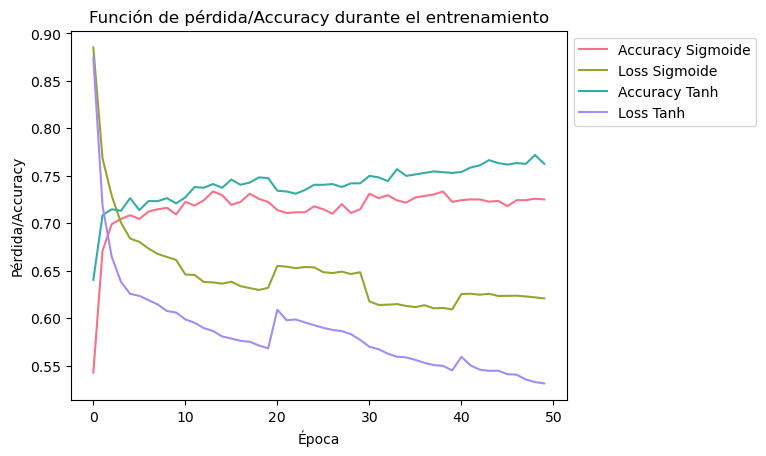

In [99]:
grafica_comparativa(clas_sigmoide, clas_tanh)

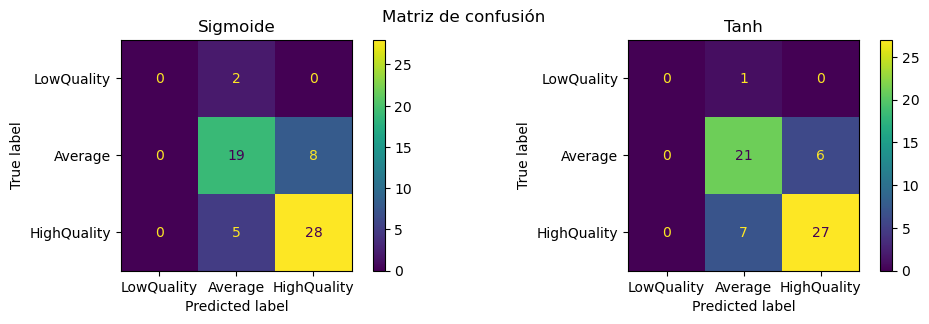

In [100]:
matriz_comparativa(clas_sigmoide, clas_tanh)

### Modelo de Regression
Para el modelo de regresión de vinos tintos, al igual que en los vinos blancos, podemos ver que los errores (cuadrático y absoluto medio), son dentro de todo similares (esta vez mas existe menor diferencia entre ellos comparando esa diferencia entre errores de los vinos blancos). La funcion tangente hiperbólica (tanh) presenta errores mas pequeños a comparanción de la función sigmoidal. Esto nos lleva a concluir que la función de activación de la tangente hiperbólica sería la mas adecuada a implementar en este modelo.

In [101]:
tabla_comparative(reg_sigmoide, reg_tanh, "MSE", "MAE")

,Función de activación,Sigmoid,Tanh
0,MSE,0.461825,0.405249
1,MAE,0.527262,0.493093


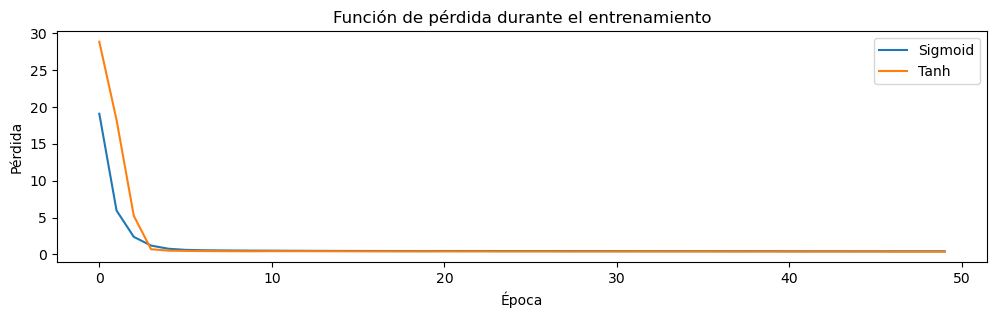

In [102]:
grafica_reg(reg_sigmoide, reg_tanh)